In [1]:

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:

# Load your data
essays = pd.read_csv('train_essays.csv')
print(essays.head(10))  


         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   
5  00da8c32          1  The electrol college system is an unfair syste...   
6  011dc2bc          1  Dear state senator, It is the utmost respect t...   
7  01448434          0  Fellow citizens, cars have become a major role...   
8  01c6e176          1  "It's official: The electoral college is unfai...   
9  0202ddf9          1  The Electoral College has been kept for centur...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0  
8          0  
9 

In [3]:

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and stem the words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)


In [4]:

# Preprocess your data
# Apply the preprocessing function and create a new column
essays['cleaned_text'] = essays['text'].apply(preprocess_text)

# Print the number of preprocessed texts
print(f"Number of preprocessed texts: {len(essays['cleaned_text'])}")

# Print the first preprocessed text
print(f"First preprocessed text: {essays['cleaned_text'].iloc[0]}")


Number of preprocessed texts: 1378
First preprocessed text: car car around sinc becam famou henri ford creat built first modelt car play major role everi day live sinc peopl start question limit car usag would good thing limit use car might good thing like matter articl german suburb life goe without car elizabeth rosenth state automobil linchpin suburb middl class famili either shanghai chicago tend make home expert say huge impedi current effort reduc greenhous ga emiss tailpip passeng car respons percent greenhous ga emiss europ percent carintens area unit state car main reason greenhous ga emiss lot peopl drive around time get need go articl pari ban drive due smog robert duffer say pari day nearrecord pollut enforc partial drive ban clear air global citi also say monday motorist evennumb licens plate order leav car home fine euro fine order would appli oddnumb plate follow day car reason pollut entir citi like pari show bad car pollut caus entir citi likewis articl carfre day spin

In [5]:

# Extract features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(essays['cleaned_text'])
y = essays['generated']

print(X)
print(y)


  (0, 1534)	22
  (0, 669)	3
  (0, 8853)	2
  (0, 955)	1
  (0, 3814)	1
  (0, 4658)	1
  (0, 4051)	1
  (0, 2382)	1
  (0, 1348)	1
  (0, 3950)	1
  (0, 6251)	1
  (0, 7323)	1
  (0, 5956)	1
  (0, 8426)	1
  (0, 3571)	1
  (0, 2494)	8
  (0, 5827)	1
  (0, 7168)	4
  (0, 9200)	1
  (0, 7868)	1
  (0, 5787)	5
  (0, 10475)	1
  (0, 11025)	3
  (0, 4349)	5
  (0, 9751)	5
  :	:
  (1377, 6977)	1
  (1377, 8562)	2
  (1377, 4749)	1
  (1377, 8990)	1
  (1377, 5128)	1
  (1377, 5645)	1
  (1377, 8141)	1
  (1377, 7080)	1
  (1377, 9589)	1
  (1377, 7145)	1
  (1377, 2005)	1
  (1377, 11039)	1
  (1377, 2151)	1
  (1377, 6476)	1
  (1377, 4146)	1
  (1377, 7089)	1
  (1377, 9421)	1
  (1377, 8517)	1
  (1377, 1369)	1
  (1377, 1783)	1
  (1377, 10073)	1
  (1377, 1241)	1
  (1377, 10461)	1
  (1377, 783)	1
  (1377, 2282)	1
0       0
1       0
2       0
3       0
4       0
       ..
1373    0
1374    0
1375    0
1376    0
1377    0
Name: generated, Length: 1378, dtype: int64


In [6]:

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:

# Train your model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [8]:

# Make predictions on your test set
predictions = model.predict(X_test)
print(predictions)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:

# Print the column names
print(y_test.columns)
print(predictions.columns)


AttributeError: 'Series' object has no attribute 'columns'

In [10]:

# AUC - ROC curve
def plot_roc(y_true, y_score, label, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label} AUC = {roc_auc_score(y_true, y_score):.2f}")



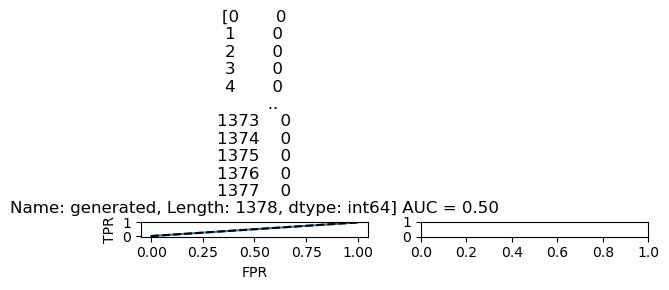

In [11]:

# auc-roc curve chart for training set
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

plot_roc(y_test, predictions, [y], ax=ax[0])

fig.tight_layout()
plt.show()


In [15]:

# Evaluate your model
print(f'Accuracy: {accuracy_score(y_test, predictions) * 100:.2f} %')


Accuracy: 99.64 %
